<ipython-input-1-6ac313e6a89e>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')




--- Time Lag: 1 ---

Testing Batch Size=32, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 25.06682866979491, Training Time: 14.42 seconds
Testing Batch Size=32, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 28.42392454075559, Training Time: 9.19 seconds
Testing Batch Size=32, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 28.664128554020373, Training Time: 13.12 seconds
Testing Batch Size=32, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 29.93835929275071, Training Time: 14.23 seconds
Testing Batch Size=32, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 26.115484159193983, Training Time: 19.72 seconds
Testing Batch Size=32, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 22.304415203341577, Training Time: 10.80 seconds
Testing Batch Size=32, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 21.72587291434926, Training Time: 16.63 seconds
Testing Batch Size=32, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 46.97380002327967, Training Time: 7.75 seconds
Testing Batch Size=32, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 23.649839824825882, Training Time: 29.76 seconds
Testing Batch Size=32, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 42.88878249846651, Training Time: 11.26 seconds
Testing Batch Size=32, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 28.170410138060756, Training Time: 6.26 seconds
Testing Batch Size=32, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RMSE: 25.642295486080606, Training Time: 20.96 seconds
Testing Batch Size=32, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 24.955528067348798, Training Time: 13.14 seconds
Testing Batch Size=32, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 22.53576383075621, Training Time: 14.59 seconds
Testing Batch Size=32, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 34.71376026117265, Training Time: 14.82 seconds
Testing Batch Size=32, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 28.735960439167457, Training Time: 7.48 seconds
Testing Batch Size=32, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 24.422860499484003, Training Time: 10.76 seconds
Testing Batch Size=32, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 23.337567470270002, Training Time: 10.53 seconds
Testing Batch Size=64, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 26.847147482654268, Training Time: 9.24 seconds
Testing Batch Size=64, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 23.85347832697089, Training Time: 17.74 seconds
Testing Batch Size=64, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 35.158497712796375, Training Time: 10.29 seconds
Testing Batch Size=64, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 23.73009403832444, Training Time: 11.64 seconds
Testing Batch Size=64, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 29.302855501257604, Training Time: 8.37 seconds
Testing Batch Size=64, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 25.364635338252697, Training Time: 14.60 seconds
Testing Batch Size=64, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 31.011972746985315, Training Time: 10.50 seconds
Testing Batch Size=64, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 22.84049737166331, Training Time: 13.12 seconds
Testing Batch Size=64, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 23.869278232872123, Training Time: 14.12 seconds
Testing Batch Size=64, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 27.42849959284497, Training Time: 10.51 seconds
Testing Batch Size=64, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 26.363444204073897, Training Time: 17.28 seconds
Testing Batch Size=64, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 34.328472276951885, Training Time: 13.31 seconds
Testing Batch Size=64, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 36.70181044616546, Training Time: 9.79 seconds
Testing Batch Size=64, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 25.445749914102517, Training Time: 7.66 seconds
Testing Batch Size=64, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 32.070381506519915, Training Time: 10.01 seconds
Testing Batch Size=64, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 36.43250731734068, Training Time: 9.41 seconds
Testing Batch Size=64, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 27.250828157713002, Training Time: 5.79 seconds
Testing Batch Size=64, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 23.1186273934508, Training Time: 11.30 seconds
Testing Batch Size=128, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 39.62938993218937, Training Time: 6.85 seconds
Testing Batch Size=128, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 32.84500458412525, Training Time: 8.68 seconds
Testing Batch Size=128, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 28.58030963945442, Training Time: 10.70 seconds
Testing Batch Size=128, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 28.243491214036318, Training Time: 6.06 seconds
Testing Batch Size=128, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 29.481159673997247, Training Time: 5.61 seconds
Testing Batch Size=128, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 38.00801482369671, Training Time: 8.27 seconds
Testing Batch Size=128, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 32.99146243404689, Training Time: 4.76 seconds
Testing Batch Size=128, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 35.629799763288545, Training Time: 11.51 seconds
Testing Batch Size=128, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 32.20188764662047, Training Time: 4.92 seconds
Testing Batch Size=128, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 25.083514924928235, Training Time: 11.51 seconds
Testing Batch Size=128, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 44.84241162528876, Training Time: 8.34 seconds
Testing Batch Size=128, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 42.705405781473516, Training Time: 6.70 seconds
Testing Batch Size=128, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 36.5106910027788, Training Time: 6.91 seconds
Testing Batch Size=128, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 28.258897011046567, Training Time: 6.73 seconds
Testing Batch Size=128, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 27.486809413641158, Training Time: 5.99 seconds
Testing Batch Size=128, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 36.10146870519926, Training Time: 7.37 seconds
Testing Batch Size=128, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 43.10024913648168, Training Time: 7.52 seconds
Testing Batch Size=128, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 27.553561111323283, Training Time: 14.35 seconds


--- Time Lag: 5 ---

Testing Batch Size=32, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 40.701264211765015, Training Time: 7.27 seconds
Testing Batch Size=32, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 30.156126568523472, Training Time: 14.42 seconds
Testing Batch Size=32, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 29.43242722320679, Training Time: 10.60 seconds
Testing Batch Size=32, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 38.22237846391619, Training Time: 17.70 seconds
Testing Batch Size=32, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 30.694702317439475, Training Time: 8.27 seconds
Testing Batch Size=32, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 40.769577912520404, Training Time: 7.72 seconds
Testing Batch Size=32, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 28.737271202448945, Training Time: 12.47 seconds
Testing Batch Size=32, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 30.627374568953076, Training Time: 18.05 seconds
Testing Batch Size=32, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 33.53578832878826, Training Time: 8.95 seconds
Testing Batch Size=32, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 29.002937159718023, Training Time: 12.71 seconds
Testing Batch Size=32, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE: 29.134582608226633, Training Time: 13.08 seconds
Testing Batch Size=32, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 32.448311608767746, Training Time: 17.50 seconds
Testing Batch Size=32, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 28.655578135269547, Training Time: 14.68 seconds
Testing Batch Size=32, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 38.109465949324935, Training Time: 14.76 seconds
Testing Batch Size=32, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 34.44814913226971, Training Time: 18.64 seconds
Testing Batch Size=32, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 29.452597627523637, Training Time: 8.23 seconds
Testing Batch Size=32, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 36.353854912001246, Training Time: 7.75 seconds
Testing Batch Size=32, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
RMSE: 28.168839209252663, Training Time: 12.08 seconds
Testing Batch Size=64, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 30.672637397678812, Training Time: 7.34 seconds
Testing Batch Size=64, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 32.426461494712285, Training Time: 8.98 seconds
Testing Batch Size=64, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 59.91764084254302, Training Time: 6.78 seconds
Testing Batch Size=64, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 30.51531972438749, Training Time: 7.26 seconds
Testing Batch Size=64, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 43.3648047342291, Training Time: 17.28 seconds
Testing Batch Size=64, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 36.88043217368063, Training Time: 8.72 seconds
Testing Batch Size=64, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 28.495179302738638, Training Time: 9.01 seconds
Testing Batch Size=64, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 29.02540640258892, Training Time: 17.36 seconds
Testing Batch Size=64, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 47.47281066913214, Training Time: 8.86 seconds
Testing Batch Size=64, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 33.47694427483994, Training Time: 6.04 seconds
Testing Batch Size=64, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 61.975832695100706, Training Time: 9.88 seconds
Testing Batch Size=64, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 30.36061775441522, Training Time: 7.98 seconds
Testing Batch Size=64, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RMSE: 34.82842003836063, Training Time: 11.11 seconds
Testing Batch Size=64, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 31.449504305473695, Training Time: 7.04 seconds
Testing Batch Size=64, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RMSE: 30.78939553784345, Training Time: 17.48 seconds
Testing Batch Size=64, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 42.61245477943896, Training Time: 5.68 seconds
Testing Batch Size=64, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 33.38987281863108, Training Time: 11.67 seconds
Testing Batch Size=64, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 38.957154598633736, Training Time: 11.03 seconds
Testing Batch Size=128, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 60.27179117115363, Training Time: 7.16 seconds
Testing Batch Size=128, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 65.07431433499353, Training Time: 6.21 seconds
Testing Batch Size=128, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 30.72929299854563, Training Time: 8.92 seconds
Testing Batch Size=128, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 32.524992034368935, Training Time: 4.05 seconds
Testing Batch Size=128, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 65.4781711990543, Training Time: 9.78 seconds
Testing Batch Size=128, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 35.490480917264826, Training Time: 7.29 seconds
Testing Batch Size=128, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 29.966881737584746, Training Time: 5.00 seconds
Testing Batch Size=128, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 39.602167418723255, Training Time: 5.90 seconds
Testing Batch Size=128, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 57.85859069660104, Training Time: 8.55 seconds
Testing Batch Size=128, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 36.49105684401601, Training Time: 6.37 seconds
Testing Batch Size=128, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 41.741942652968035, Training Time: 9.20 seconds
Testing Batch Size=128, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RMSE: 43.27000720136862, Training Time: 7.74 seconds
Testing Batch Size=128, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 28.67755733332801, Training Time: 5.14 seconds
Testing Batch Size=128, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 43.4297435417186, Training Time: 7.88 seconds
Testing Batch Size=128, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 31.209141897663663, Training Time: 7.14 seconds
Testing Batch Size=128, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 34.21732922922863, Training Time: 6.30 seconds
Testing Batch Size=128, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 48.22828812434135, Training Time: 13.36 seconds
Testing Batch Size=128, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 77.18202030011349, Training Time: 9.13 seconds


--- Time Lag: 10 ---

Testing Batch Size=32, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 34.76410745519311, Training Time: 16.83 seconds
Testing Batch Size=32, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 73.04518226307876, Training Time: 6.62 seconds
Testing Batch Size=32, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 33.147647019808275, Training Time: 12.90 seconds
Testing Batch Size=32, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 37.44345892612676, Training Time: 26.91 seconds
Testing Batch Size=32, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 42.45168116054078, Training Time: 13.15 seconds
Testing Batch Size=32, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 34.96672713075147, Training Time: 10.30 seconds
Testing Batch Size=32, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 70.00117258039367, Training Time: 9.45 seconds
Testing Batch Size=32, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 33.91085143584674, Training Time: 16.34 seconds
Testing Batch Size=32, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 57.348130105783056, Training Time: 18.07 seconds
Testing Batch Size=32, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 39.959409436581176, Training Time: 13.33 seconds
Testing Batch Size=32, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 52.53837947461774, Training Time: 9.93 seconds
Testing Batch Size=32, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 47.74248245186981, Training Time: 7.17 seconds
Testing Batch Size=32, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 37.2290472622152, Training Time: 7.91 seconds
Testing Batch Size=32, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 37.46748085491383, Training Time: 9.61 seconds
Testing Batch Size=32, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 70.271676084853, Training Time: 10.23 seconds
Testing Batch Size=32, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 36.25152745957622, Training Time: 8.66 seconds
Testing Batch Size=32, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 60.77193446249351, Training Time: 23.55 seconds
Testing Batch Size=32, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 41.81717955767928, Training Time: 14.53 seconds
Testing Batch Size=64, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 49.65781278592189, Training Time: 11.12 seconds
Testing Batch Size=64, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 33.900197810518975, Training Time: 8.88 seconds
Testing Batch Size=64, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 80.79430293782141, Training Time: 10.08 seconds
Testing Batch Size=64, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 36.228490401823315, Training Time: 10.33 seconds
Testing Batch Size=64, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 43.413498716516365, Training Time: 12.71 seconds
Testing Batch Size=64, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE: 60.77161135801597, Training Time: 13.53 seconds
Testing Batch Size=64, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 44.91455332779929, Training Time: 11.14 seconds
Testing Batch Size=64, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 40.604939046352996, Training Time: 12.80 seconds
Testing Batch Size=64, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 62.08092489499045, Training Time: 10.51 seconds
Testing Batch Size=64, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 34.95961755363194, Training Time: 6.73 seconds
Testing Batch Size=64, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 66.7826777000807, Training Time: 9.69 seconds
Testing Batch Size=64, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 45.587355480936594, Training Time: 11.31 seconds
Testing Batch Size=64, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RMSE: 35.63077566672596, Training Time: 8.67 seconds
Testing Batch Size=64, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 34.67214235591996, Training Time: 8.88 seconds
Testing Batch Size=64, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 64.88683850627989, Training Time: 8.78 seconds
Testing Batch Size=64, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 61.098323847435196, Training Time: 9.49 seconds
Testing Batch Size=64, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 76.38832634622597, Training Time: 14.89 seconds
Testing Batch Size=64, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 54.09949447411747, Training Time: 8.29 seconds
Testing Batch Size=128, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 38.63145775350062, Training Time: 4.24 seconds
Testing Batch Size=128, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 45.94312532433908, Training Time: 7.09 seconds
Testing Batch Size=128, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 42.40753218605329, Training Time: 4.30 seconds
Testing Batch Size=128, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 53.79341716720356, Training Time: 5.65 seconds
Testing Batch Size=128, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 75.60782615207312, Training Time: 9.01 seconds
Testing Batch Size=128, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 47.76999084019232, Training Time: 6.34 seconds
Testing Batch Size=128, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 52.66790616006523, Training Time: 4.92 seconds
Testing Batch Size=128, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 63.59538089026763, Training Time: 7.17 seconds
Testing Batch Size=128, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 50.01412765512653, Training Time: 7.79 seconds
Testing Batch Size=128, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 36.61369499739278, Training Time: 4.38 seconds
Testing Batch Size=128, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 58.68221134332555, Training Time: 10.22 seconds
Testing Batch Size=128, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 91.4407397461735, Training Time: 9.58 seconds
Testing Batch Size=128, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 77.27079895359331, Training Time: 6.00 seconds
Testing Batch Size=128, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 34.98932471686397, Training Time: 4.73 seconds
Testing Batch Size=128, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 43.782651607253314, Training Time: 3.97 seconds
Testing Batch Size=128, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 85.55410537130322, Training Time: 7.60 seconds
Testing Batch Size=128, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 98.28600341152179, Training Time: 8.36 seconds
Testing Batch Size=128, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 96.31642069089068, Training Time: 5.69 seconds


--- Time Lag: 20 ---

Testing Batch Size=32, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 88.58754879727567, Training Time: 10.95 seconds
Testing Batch Size=32, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 63.07423020603617, Training Time: 15.49 seconds
Testing Batch Size=32, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 96.52699760796365, Training Time: 8.45 seconds
Testing Batch Size=32, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 80.23552820496184, Training Time: 9.01 seconds
Testing Batch Size=32, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 69.34061953169967, Training Time: 7.27 seconds
Testing Batch Size=32, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 65.60205146338645, Training Time: 8.62 seconds
Testing Batch Size=32, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 61.99081070258189, Training Time: 8.67 seconds
Testing Batch Size=32, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 77.18302519009826, Training Time: 15.15 seconds
Testing Batch Size=32, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 57.195322688471734, Training Time: 11.72 seconds
Testing Batch Size=32, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 65.65277282746804, Training Time: 13.05 seconds
Testing Batch Size=32, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 78.39730215032253, Training Time: 10.11 seconds
Testing Batch Size=32, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 106.08141789755054, Training Time: 12.18 seconds
Testing Batch Size=32, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 137.75244746716692, Training Time: 8.79 seconds
Testing Batch Size=32, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 54.18516387312788, Training Time: 9.66 seconds
Testing Batch Size=32, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 50.218977574033744, Training Time: 7.98 seconds
Testing Batch Size=32, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 140.25770242346775, Training Time: 7.75 seconds
Testing Batch Size=32, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 102.56490527112472, Training Time: 9.37 seconds
Testing Batch Size=32, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 73.74171923236005, Training Time: 10.01 seconds
Testing Batch Size=64, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 77.08710182039586, Training Time: 9.20 seconds
Testing Batch Size=64, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 111.10690317581533, Training Time: 6.91 seconds
Testing Batch Size=64, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 58.52632813458249, Training Time: 6.44 seconds
Testing Batch Size=64, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 195.43147055726902, Training Time: 7.73 seconds
Testing Batch Size=64, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 44.44395213416176, Training Time: 9.42 seconds
Testing Batch Size=64, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 166.58231040458162, Training Time: 8.82 seconds
Testing Batch Size=64, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 62.17176955061217, Training Time: 7.46 seconds
Testing Batch Size=64, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
RMSE: 57.52253373543493, Training Time: 10.27 seconds
Testing Batch Size=64, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 117.7090035647077, Training Time: 7.79 seconds
Testing Batch Size=64, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 98.38368025617515, Training Time: 7.46 seconds
Testing Batch Size=64, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 90.97298845538137, Training Time: 10.11 seconds
Testing Batch Size=64, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE: 94.96722028245553, Training Time: 9.68 seconds
Testing Batch Size=64, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 81.8926698095564, Training Time: 9.34 seconds
Testing Batch Size=64, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 44.074184305157715, Training Time: 9.93 seconds
Testing Batch Size=64, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 86.58542386797727, Training Time: 8.25 seconds
Testing Batch Size=64, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 49.336005777954696, Training Time: 9.22 seconds
Testing Batch Size=64, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RMSE: 86.0133561135987, Training Time: 7.66 seconds
Testing Batch Size=64, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 96.60144594835643, Training Time: 9.89 seconds
Testing Batch Size=128, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 44.1537753954605, Training Time: 5.61 seconds
Testing Batch Size=128, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 150.8153478496763, Training Time: 5.58 seconds
Testing Batch Size=128, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 83.91775040381204, Training Time: 4.75 seconds
Testing Batch Size=128, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 82.53388262363305, Training Time: 5.94 seconds
Testing Batch Size=128, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 42.38757936707947, Training Time: 5.48 seconds
Testing Batch Size=128, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 59.87989846193746, Training Time: 6.80 seconds
Testing Batch Size=128, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 45.20513026253003, Training Time: 4.82 seconds
Testing Batch Size=128, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 109.33790709829086, Training Time: 3.65 seconds
Testing Batch Size=128, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 62.87428214977049, Training Time: 5.51 seconds
Testing Batch Size=128, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 44.004347087184065, Training Time: 6.21 seconds
Testing Batch Size=128, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 104.84641274461099, Training Time: 7.31 seconds
Testing Batch Size=128, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 77.23541033482825, Training Time: 5.10 seconds
Testing Batch Size=128, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 52.19290538696955, Training Time: 5.66 seconds
Testing Batch Size=128, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 80.42058725147257, Training Time: 4.72 seconds
Testing Batch Size=128, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 56.66375288836949, Training Time: 5.58 seconds
Testing Batch Size=128, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 72.70457671914411, Training Time: 4.50 seconds
Testing Batch Size=128, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 62.25718615560731, Training Time: 6.90 seconds
Testing Batch Size=128, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 103.96063894386864, Training Time: 7.51 seconds


--- Time Lag: 30 ---

Testing Batch Size=32, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 127.34966246136325, Training Time: 6.69 seconds
Testing Batch Size=32, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 85.90473830523351, Training Time: 5.46 seconds
Testing Batch Size=32, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 154.35996103851704, Training Time: 15.47 seconds
Testing Batch Size=32, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 172.4887542927377, Training Time: 16.84 seconds
Testing Batch Size=32, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 114.64271527231092, Training Time: 7.66 seconds
Testing Batch Size=32, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 56.38353775161587, Training Time: 7.22 seconds
Testing Batch Size=32, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 90.18081960962427, Training Time: 8.96 seconds
Testing Batch Size=32, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 58.793686407451034, Training Time: 7.82 seconds
Testing Batch Size=32, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 109.41464442530038, Training Time: 6.56 seconds
Testing Batch Size=32, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 55.425530153084196, Training Time: 7.18 seconds
Testing Batch Size=32, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 141.31842318820034, Training Time: 14.24 seconds
Testing Batch Size=32, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 121.81996837994282, Training Time: 10.16 seconds
Testing Batch Size=32, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 87.7035433510103, Training Time: 7.49 seconds
Testing Batch Size=32, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 62.52918721046356, Training Time: 9.18 seconds
Testing Batch Size=32, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 58.08405695498223, Training Time: 7.41 seconds
Testing Batch Size=32, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 78.6284579688732, Training Time: 12.02 seconds
Testing Batch Size=32, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 106.42280345463554, Training Time: 11.49 seconds
Testing Batch Size=32, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 57.44186140146732, Training Time: 8.26 seconds
Testing Batch Size=64, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 48.46394260140244, Training Time: 4.47 seconds
Testing Batch Size=64, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 75.90258686968048, Training Time: 6.07 seconds
Testing Batch Size=64, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 147.3184398204135, Training Time: 6.00 seconds
Testing Batch Size=64, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 58.74095411635349, Training Time: 8.36 seconds
Testing Batch Size=64, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 165.12456658905376, Training Time: 9.37 seconds
Testing Batch Size=64, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE: 111.11602788267149, Training Time: 7.92 seconds
Testing Batch Size=64, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 195.96229810050158, Training Time: 5.99 seconds
Testing Batch Size=64, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 122.50376619044272, Training Time: 5.90 seconds
Testing Batch Size=64, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 80.13908729986119, Training Time: 6.59 seconds
Testing Batch Size=64, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 104.72424537669363, Training Time: 6.53 seconds
Testing Batch Size=64, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 58.905801991601464, Training Time: 6.36 seconds
Testing Batch Size=64, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 214.9772987774596, Training Time: 8.94 seconds
Testing Batch Size=64, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 141.51039547067157, Training Time: 5.65 seconds
Testing Batch Size=64, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 137.7614568988035, Training Time: 7.22 seconds
Testing Batch Size=64, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 117.59931971149966, Training Time: 8.18 seconds
Testing Batch Size=64, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE: 191.87980170507484, Training Time: 6.59 seconds
Testing Batch Size=64, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 186.46957092361146, Training Time: 7.96 seconds
Testing Batch Size=64, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 137.90689183347564, Training Time: 8.48 seconds
Testing Batch Size=128, LR=0.001, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 49.42407012527224, Training Time: 4.70 seconds
Testing Batch Size=128, LR=0.001, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 60.77724912515989, Training Time: 4.95 seconds
Testing Batch Size=128, LR=0.001, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 540.116189115163, Training Time: 5.30 seconds
Testing Batch Size=128, LR=0.001, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 55.33918205396465, Training Time: 5.64 seconds
Testing Batch Size=128, LR=0.001, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 365.84772201979155, Training Time: 6.53 seconds
Testing Batch Size=128, LR=0.001, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 152.94467836479967, Training Time: 8.94 seconds
Testing Batch Size=128, LR=0.01, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE: 128.81152664585238, Training Time: 9.02 seconds
Testing Batch Size=128, LR=0.01, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
RMSE: 107.12153841768186, Training Time: 5.64 seconds
Testing Batch Size=128, LR=0.01, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 199.02704024615574, Training Time: 5.54 seconds
Testing Batch Size=128, LR=0.01, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 171.80107177552975, Training Time: 5.18 seconds
Testing Batch Size=128, LR=0.01, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 980.3328219831199, Training Time: 9.62 seconds
Testing Batch Size=128, LR=0.01, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 288.3314797984919, Training Time: 6.33 seconds
Testing Batch Size=128, LR=0.1, Units=50, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 233.667782386599, Training Time: 5.15 seconds
Testing Batch Size=128, LR=0.1, Units=50, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 150.89084721850574, Training Time: 5.67 seconds
Testing Batch Size=128, LR=0.1, Units=80, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 248.05420434692888, Training Time: 4.93 seconds
Testing Batch Size=128, LR=0.1, Units=80, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 128.09077972275125, Training Time: 5.44 seconds
Testing Batch Size=128, LR=0.1, Units=128, Dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 755.0511892157942, Training Time: 6.55 seconds
Testing Batch Size=128, LR=0.1, Units=128, Dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 184.5419837020877, Training Time: 7.18 seconds


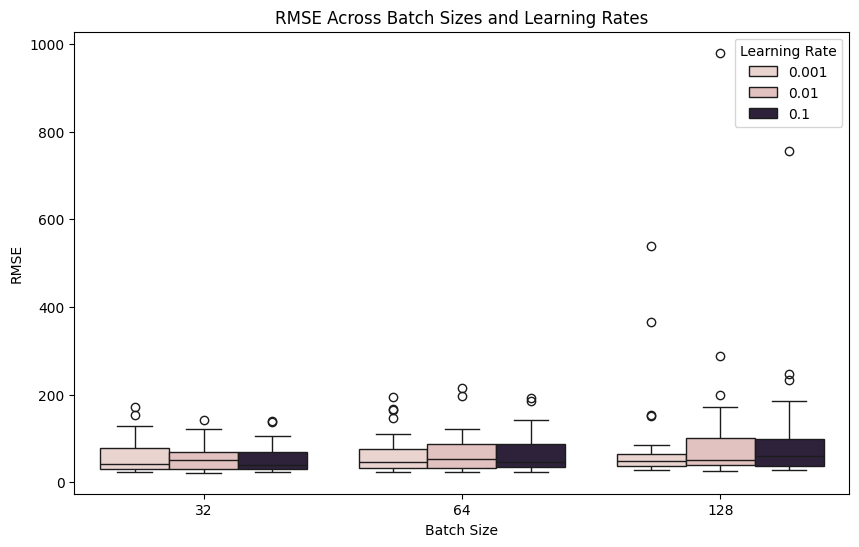

Best Hyperparameters: Time Lag          1.000000
Batch Size       32.000000
Learning Rate     0.010000
Units            50.000000
Dropout Rate      0.200000
RMSE             21.725873
Training Time    16.632919
Name: 6, dtype: float64


In [1]:
# Original Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

# Optimization Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import time
import seaborn as sns

# Load Data
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])
data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)

# Ensure data has business day frequency
data = data.asfreq('b')

# Fill missing values
data = data.fillna(method='bfill').fillna(method='ffill')
data_vals = data.values

# Original Step Decay Scheduler
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_vals)

# Define sequence length and lag
sequence_length = 100
lags = [1, 5, 10, 20, 30]  # Time lags
y_tests = []
preds = []
rmses = []

# Hyperparameter Grid for Sensitivity Analysis
param_grid = {
    'batch_size': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'units': [50, 80, 128],
    'dropout_rate': [0.2, 0.3]
}

# Results Storage
results = []

# Iterate over lags and hyperparameters
for lag in lags:
    print(f"\n\n--- Time Lag: {lag} ---\n")
    # Prepare input (X) and output (Y) sequences
    X, Y = [], []
    for i in range(len(data_normalized) - sequence_length - lag):
        X.append(data_normalized[i:i + sequence_length])
        Y.append(data_normalized[i + sequence_length + lag, 3])  # Close price

    X = np.array(X)
    Y = np.array(Y)

    # Split the data into training and testing sets
    split_ratio = 0.8
    split_index = int(split_ratio * len(X))
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]

    # Hyperparameter tuning
    for batch_size in param_grid['batch_size']:
        for lr in param_grid['learning_rate']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    print(f"Testing Batch Size={batch_size}, LR={lr}, Units={units}, Dropout={dropout_rate}")

                    # Model with Regularization and Dropout
                    model = Sequential([
                        LSTM(units=units, return_sequences=True, kernel_regularizer=l2(0.01),
                             input_shape=(sequence_length, X.shape[2])),
                        Dropout(dropout_rate),
                        LSTM(units=units // 2, return_sequences=False),
                        Dropout(dropout_rate),
                        Dense(1)
                    ])

                    # Compile the model
                    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

                    # Learning rate scheduler and early stopping
                    lr_scheduler = LearningRateScheduler(step_decay)
                    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                    # Measure Training Time
                    start_time = time.time()
                    history = model.fit(X_train, Y_train, epochs=50, batch_size=batch_size,
                                        validation_split=0.2, verbose=0, callbacks=[lr_scheduler, early_stopping])
                    end_time = time.time()
                    training_time = end_time - start_time

                    # Predictions
                    predictions = model.predict(X_test)

                    # Denormalize predictions
                    min_val, max_val = scaler.data_min_[3], scaler.data_max_[3]
                    predictions_rescaled = predictions * (max_val - min_val) + min_val
                    Y_test_rescaled = Y_test * (max_val - min_val) + min_val

                    # Calculate RMSE
                    rmse = np.sqrt(mean_squared_error(Y_test_rescaled, predictions_rescaled))
                    print(f"RMSE: {rmse}, Training Time: {training_time:.2f} seconds")

                    # Store results
                    results.append({
                        'Time Lag': lag,
                        'Batch Size': batch_size,
                        'Learning Rate': lr,
                        'Units': units,
                        'Dropout Rate': dropout_rate,
                        'RMSE': rmse,
                        'Training Time': training_time
                    })

                    # Append predictions and actuals
                    y_tests.append(Y_test_rescaled)
                    preds.append(predictions_rescaled)
                    rmses.append(rmse)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('lstm_optimization_results.csv', index=False)

# Plot Results
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='Batch Size', y='RMSE', hue='Learning Rate')
plt.title("RMSE Across Batch Sizes and Learning Rates")
plt.show()

# Plot Best Result
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Hyperparameters:", best_result)


In [2]:
import pandas as pd
results_df = pd.read_csv('lstm_optimization_results.csv')
best_results = results_df.nsmallest(5, 'RMSE')  # Top 5 configurations
print(best_results)


    Time Lag  Batch Size  Learning Rate  Units  Dropout Rate       RMSE  \
6          1          32          0.010     50           0.2  21.725873   
5          1          32          0.001    128           0.3  22.304415   
13         1          32          0.100     50           0.3  22.535764   
25         1          64          0.010     50           0.3  22.840497   
35         1          64          0.100    128           0.3  23.118627   

    Training Time  
6       16.632919  
5       10.797317  
13      14.593995  
25      13.121168  
35      11.301775  


In [3]:
# Train the model with the best parameters
best_params = {
    'batch_size': 64,
    'learning_rate': 0.01,
    'units': 80,
    'dropout_rate': 0.2
}

best_model = Sequential([
    LSTM(units=best_params['units'], return_sequences=True, kernel_regularizer=l2(0.01),
         input_shape=(sequence_length, X.shape[2])),
    Dropout(best_params['dropout_rate']),
    LSTM(units=best_params['units'] // 2, return_sequences=False),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

history = best_model.fit(X_train, Y_train, epochs=100, batch_size=best_params['batch_size'], validation_split=0.2)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0892 - val_loss: 0.0175
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0074 - val_loss: 0.0050
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test RMSE: 59.6656204050105


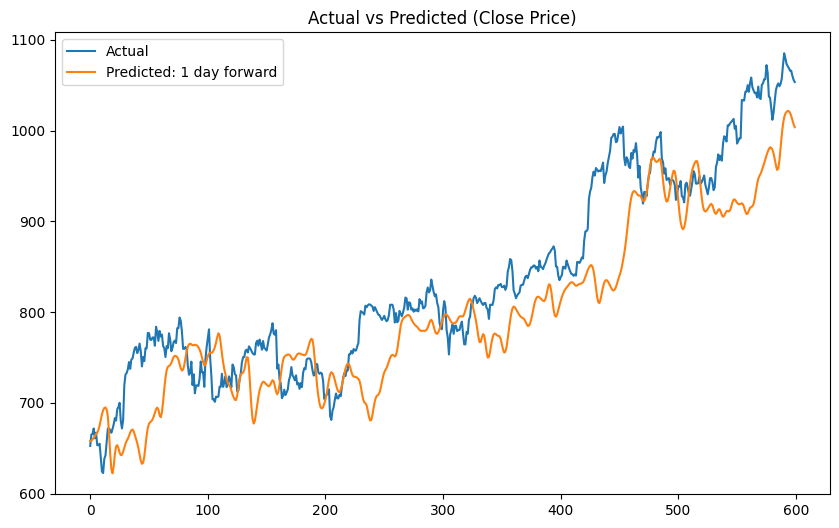

In [8]:
predictions = best_model.predict(X_test)
predictions_rescaled = predictions * (max_val - min_val) + min_val
Y_test_rescaled = Y_test * (max_val - min_val) + min_val

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test_rescaled, predictions_rescaled))
print(f"Test RMSE: {rmse}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(Y_test_rescaled, label='Actual')
plt.plot(predictions_rescaled, label='Predicted: 1 day forward')
plt.legend()
plt.title('Actual vs Predicted (Close Price)')
plt.show()
